<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 335 (delta 88), reused 166 (delta 36), pack-reused 80 (from 1)
Receiving objects: 100% (335/335), 230.49 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Updating files: 100% (56/56), done.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [4]:
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df.head()

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          329352.88                   48  20.704082      15.2      26.0   
1          323133.95                   48  20.572917      14.9      24.2   
2          317665.92                   48  21.130769      19.0      22.9   
3          353210.40                   48  20.144444      18.4      23.1   
4          358082.97                   48  18.904808      17.4      20.3   

   hd_next_24h  cd_next_24h  precipitation  sunlight  
0          0.0     1.204082       2.140095      32.3  
1          0.0     1.072917       6.496326      23.2  
2          0.0     1.630769       8.562486      12.7  
3          0.0     0.644444       4.082204       7.6  
4          0.0     0.000000       9.977372       3.9  

[5 rows x 38 columns]

In [5]:
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2016-01-01          1          0          0          0          0   
1     2016-01-02          1          0          0          0          0   
2     2016-01-03          1          0          0          0          1   
3     2016-01-04          1          0          0          0          0   
4     2016-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
1456  2019-12-27          1          0          0          0          0   
1457  2019-12-28          1          0          0          0          0   
1458  2019-12-29          1          0          0          0          1   
1459  2019-12-30          1          0          0          0          0   
1460  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
1456          0           0             0            0  ...   
1457          0           0             0            0  ...   
1458          0           0             0            0  ...   
1459          1           0             0            0  ...   
1460          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               7913.75          329352.88                   48  20.704082   
1               7390.04          323133.95                   48  20.572917   
2               7328.39          317665.92                   48  21.130769   
3               8313.11          353210.40                   48  20.144444   
4               8338.82          358082.97                   48  18.904808   
...                 ...                ...                  ...        ...   
1456            9324.59          360393.59                   48  23.654717   
1457            9806.43          369325.03                   48  24.309615   
1458            9773.20          371819.56                   48  23.689583   
1459           10848.99          399427.25                   48  24.172917   
1460           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         15.2      26.0          0.0     1.204082       2.140095      32.3  
1         14.9      24.2          0.0     1.072917       6.496326      23.2  
2         19.0      22.9          0.0     1.630769       8.562486      12.7  
3         18.4      23.1          0.0     0.644444       4.082204       7.6  
4         17.4      20.3          0.0     0.000000       9.977372       3.9  
...        ...       ...          ...          ...            ...       ...  
1456      19.2      28.5          0.0     4.154717       0.081469      30.7  
1457      16.6      29.9          0.0     4.809615       0.571150      30.8  
1458      18.1      29.3          0.0     4.189583       0.101862      21.8  
1459      18.1      31.0          0.0     4.672917       0.243804      26.3  
1460      17.7      42.1          0.0     6.805882       1.126134      27.7  

[1461 rows x 38 columns]

In [6]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2016-01-01           1          0          0          0          0          0   
2016-01-02           1          0          0          0          0          0   
2016-01-03           1          0          0          0          1          0   
2016-01-04           1          0          0          0          0          1   
2016-01-05           1          0          0          0          0          0   
2016-01-06           1          0          0          0          0          0   
2016-01-07           1          0          0          0          0          0   
2016-01-08           1          0          0          0          0          0   
2016-01-09           1          0          0          0          0          0   
2016-01-10           1          0          0          0          1          0   
2016-01-11           1          0          0          0          0          1   
2016-01-12           1          0          0          0          0          0   
2016-01-13           1          0          0          0          0          0   
2016-01-14           1          0          0          0          0          0   
2016-01-15           1          0          0          0          0          0   
2016-01-16           1          0          0          0          0          0   
2016-01-17           1          0          0          0          1          0   
2016-01-18           1          0          0          0          0          1   
2016-01-19           1          0          0          0          0          0   
2016-01-20           1          0          0          0          0          0   
2016-01-21           1          0          0          0          0          0   
2016-01-22           1          0          0          0          0          0   
2016-01-23           1          0          0          0          0          0   
2016-01-24           1          0          0          0          1          0   
2016-01-25           1          0          0          0          0          1   
2016-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2016-01-01            0             0            0          1  ...   
2016-01-02            0             0            0          0  ...   
2016-01-03            0             0            0          0  ...   
2016-01-04            0             0            0          0  ...   
2016-01-05            1             0            0          0  ...   
2016-01-06            0             1            0          0  ...   
2016-01-07            0             0            1          0  ...   
2016-01-08            0             0            0          1  ...   
2016-01-09            0             0            0          0  ...   
2016-01-10            0             0            0          0  ...   
2016-01-11            0             0            0          0  ...   
2016-01-12            1             0            0          0  ...   
2016-01-13            0             1            0          0  ...   
2016-01-14            0             0            1          0  ...   
2016-01-15            0             0            0          1  ...   
2016-01-16            0             0            0          0  ...   
2016-01-17            0             0            0          0  ...   
2016-01-18            0             0            0          0  ...   
2016-01-19            1             0            0          0  ...   
2016-01-20            0             1            0          0  ...   
2016-01-21            0             0            1          0  ...   
2016-01-22            0             0            0          1  ...   
2016-01-23            0             0            0          0  .

In [7]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## Helper Functions ##

In [8]:
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_extended_slice(years[2], years[1])
            test_df = self._get_extended_slice(years[3], years[2])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_year_slice(years[2])
            test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def to_X_and_y(self, df_scaled, target_col='avg_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 3 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs


### Setup function for printing, metrics ###

In [30]:
def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='avg_30_min_demand'):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [14]:
## Optuna Function
def objective(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_int("n_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train18.shape[1], X_train18.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train18, y_train18, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test18, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test[:, 0]

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## 1. Base Model - Avg Demand Only ##

In [40]:
demandDF = test_df[['avg_30_min_demand']]

In [41]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

i = X_train.shape[1]
j = X_train.shape[2]

In [42]:
model1 = Sequential()
model1.add(InputLayer((i, j)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1287 - mean_absolute_percentage_error: 138907.2656 - root_mean_squared_error: 0.3560 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 34.5440 - val_root_mean_squared_error: 0.1238
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0209 - mean_absolute_percentage_error: 1247202.7500 - root_mean_squared_error: 0.1444 - val_loss: 0.0139 - val_mean_absolute_percentage_error: 35.5207 - val_root_mean_squared_error: 0.1179
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0176 - mean_absolute_percentage_error: 1047497.8750 - root_mean_squared_error: 0.1327 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 38.5992 - val_root_mean_squared_error: 0.1172
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - mean_absolute_percentage_error: 1169341.3750 - root_mean_squared_error: 0.1330 - val_loss: 0.0133 - val_mean_absolute_percentage_error: 37.0518 - val_root_mean_squared_error: 0.11

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


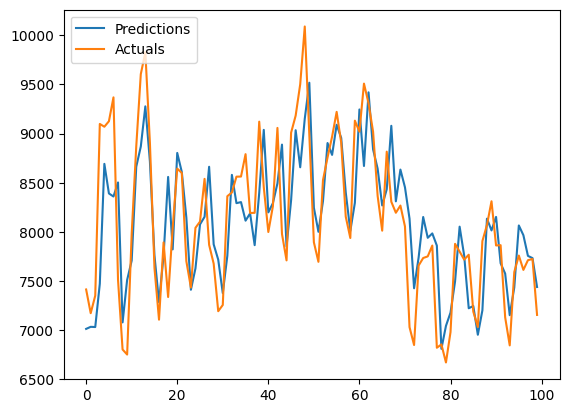

MAPE: 3.95%
RMSE: 428.73
MAE : 319.26


Predictions      Actuals
0    7011.519043  7412.811667
1    7032.392578  7171.183125
2    7030.321777  7350.264167
3    7470.803223  9098.258333
4    8691.861328  9070.002917
..           ...          ...
719  7946.890625  7374.332292
720  7907.451172  8039.583333
721  8216.280273  8575.767292
722  8460.848633  7909.507917
723  7677.116211  7144.386250

[724 rows x 2 columns]

In [44]:
model1 = load_model('model1.keras')

predictions_plot(model1, X_train, y_train, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


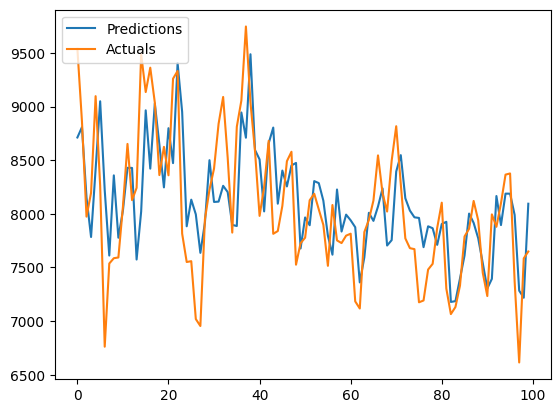

MAPE: 3.81%
RMSE: 392.74
MAE : 302.38


Predictions      Actuals
0    8711.341797  9537.097917
1    8807.253906  8863.333125
2    8153.589355  7973.787500
3    7783.900879  8194.981667
4    8416.222656  9096.434375
..           ...          ...
353  8026.561035  8447.030417
354  8148.592285  8771.408958
355  7776.879395  8487.014792
356  7562.011230  8380.489792
357  7672.249023  8437.980833

[358 rows x 2 columns]

In [45]:
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


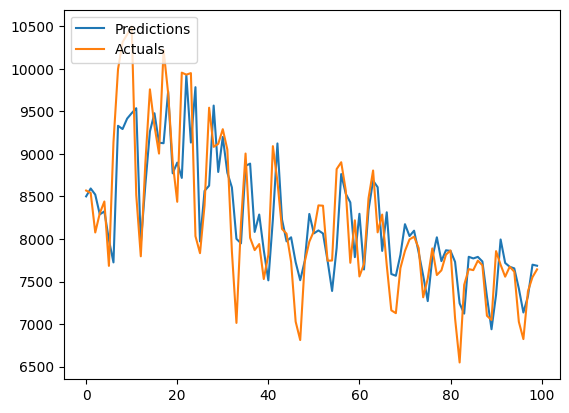

MAPE: 3.89%
RMSE: 412.74
MAE : 309.03


Predictions      Actuals
0    8501.001953  8569.568125
1    8593.641602  8540.904167
2    8521.557617  8076.513125
3    8289.165039  8302.971875
4    8324.674805  8440.820000
..           ...          ...
353  7679.666504  7508.199792
354  7825.987793  7694.271458
355  7444.710449  7746.240833
356  7618.155273  8321.401042
357  7901.217773  8503.726875

[358 rows x 2 columns]

In [46]:
predictions_plot(model1, X_test, y_test, 0, 100)

### Model 2 - Overlapping Windows ###

In [49]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

i = X_train2.shape[1]
j = X_train2.shape[2]

In [50]:
model2 = Sequential()
model2.add(InputLayer((i, j)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1223 - root_mean_squared_error: 0.3445 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1306
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0231 - root_mean_squared_error: 0.1517 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1147
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


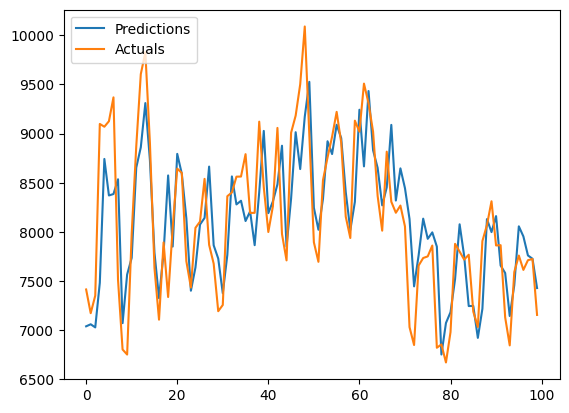

MAPE: 3.94%
RMSE: 427.57
MAE : 317.89


Predictions      Actuals
0    7037.687500  7412.811667
1    7058.405762  7171.183125
2    7026.620605  7350.264167
3    7480.571777  9098.258333
4    8741.949219  9070.002917
..           ...          ...
719  7963.329590  7374.332292
720  7884.548828  8039.583333
721  8211.394531  8575.767292
722  8480.872070  7909.507917
723  7623.435059  7144.386250

[724 rows x 2 columns]

In [52]:
model2 = load_model('model2.keras')

predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


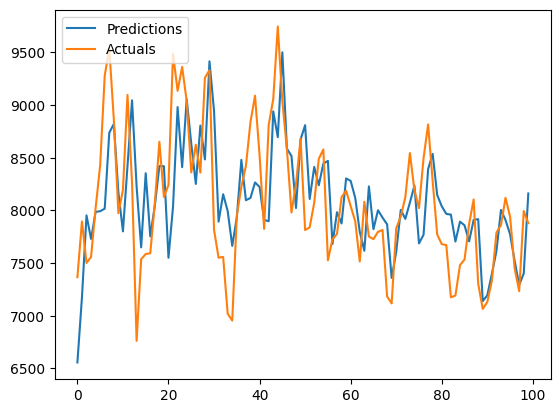

MAPE: 3.84%
RMSE: 398.43
MAE : 305.36


Predictions      Actuals
0    6556.812500  7365.989375
1    7173.702148  7895.121667
2    7952.891602  7501.373542
3    7729.173828  7557.751458
4    7986.333008  8021.308125
..           ...          ...
360  8043.841309  8447.030417
361  8194.378906  8771.408958
362  7851.762695  8487.014792
363  7555.291016  8380.489792
364  7678.375488  8437.980833

[365 rows x 2 columns]

In [53]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


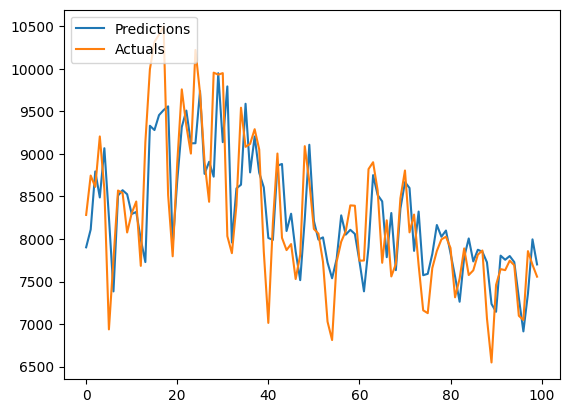

MAPE: 3.94%
RMSE: 417.68
MAE : 313.31


Predictions      Actuals
0    7902.437988  8282.850208
1    8111.990723  8745.688125
2    8794.038086  8612.550625
3    8488.431641  9205.374583
4    9066.910156  8584.935417
..           ...          ...
360  7704.608887  7508.199792
361  7819.861816  7694.271458
362  7482.642090  7746.240833
363  7621.512695  8321.401042
364  7909.293945  8503.726875

[365 rows x 2 columns]

In [54]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

## 2. Introducing Temperature... ##

In [55]:
tempDemandDF = test_df[['avg_30_min_demand', 'avg_temp']]

In [63]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [64]:
model3 = Sequential()
model3.add(InputLayer((i, j)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0466 - root_mean_squared_error: 0.2120 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1165
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - root_mean_squared_error: 0.1316 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - root_mean_squared_error: 0.1298 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1177
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1280 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


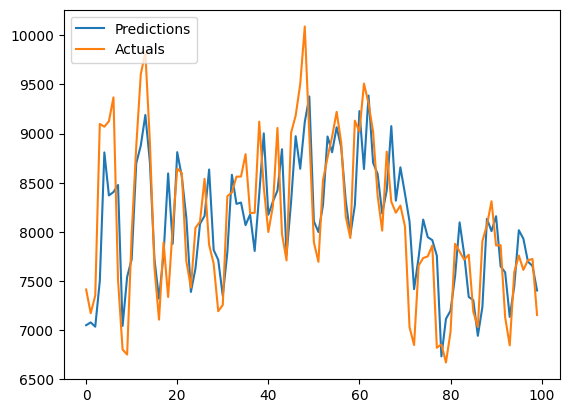

MAPE: 3.85%
RMSE: 421.98
MAE : 311.31


Predictions      Actuals
0    7048.871094  7412.811667
1    7077.371582  7171.183125
2    7033.838379  7350.264167
3    7498.985352  9098.258333
4    8808.470703  9070.002917
..           ...          ...
719  7971.470703  7374.332292
720  7933.375488  8039.583333
721  8305.059570  8575.767292
722  8499.547852  7909.507917
723  7666.854004  7144.386250

[724 rows x 2 columns]

In [66]:
model3 = load_model('model3.keras')

predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


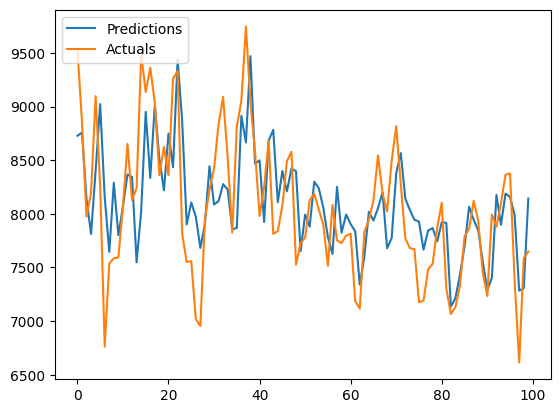

MAPE: 3.73%
RMSE: 385.36
MAE : 296.30


Predictions      Actuals
0    8726.997070  9537.097917
1    8757.073242  8863.333125
2    8139.183105  7973.787500
3    7812.113770  8194.981667
4    8400.012695  9096.434375
..           ...          ...
353  8035.208496  8447.030417
354  8319.306641  8771.408958
355  8151.360352  8487.014792
356  7753.217285  8380.489792
357  7784.423340  8437.980833

[358 rows x 2 columns]

In [67]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


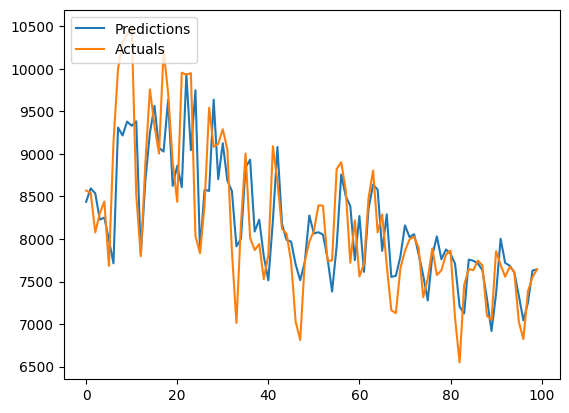

MAPE: 3.87%
RMSE: 416.18
MAE : 308.17


Predictions      Actuals
0    8437.003906  8569.568125
1    8594.943359  8540.904167
2    8536.545898  8076.513125
3    8228.054688  8302.971875
4    8251.743164  8440.820000
..           ...          ...
353  7722.506348  7508.199792
354  7894.507324  7694.271458
355  7738.135254  7746.240833
356  7811.131348  8321.401042
357  8099.491699  8503.726875

[358 rows x 2 columns]

In [68]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

## Feature Analysis ##

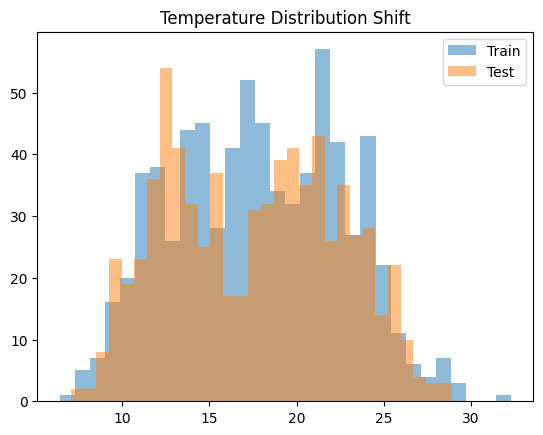

In [69]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [71]:
tempDemandDF2 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

## Model 4 ##

In [72]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

i = X_train4.shape[1]
j = X_train4.shape[2]

In [73]:
model4 = Sequential()
model4.add(InputLayer((i, j)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0517 - root_mean_squared_error: 0.2237 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


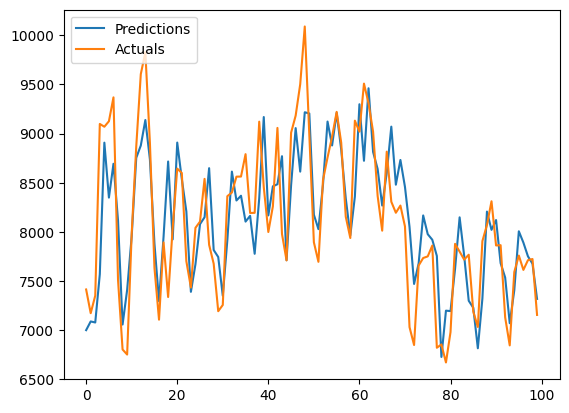

MAPE: 3.75%
RMSE: 408.36
MAE : 301.81


Predictions      Actuals
0    6998.589355  7412.811667
1    7087.234863  7171.183125
2    7076.680664  7350.264167
3    7568.183594  9098.258333
4    8907.819336  9070.002917
..           ...          ...
719  7852.887207  7374.332292
720  8030.505371  8039.583333
721  8285.114258  8575.767292
722  8406.179688  7909.507917
723  7462.598145  7144.386250

[724 rows x 2 columns]

In [75]:
model4 = load_model('model4.keras')

predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


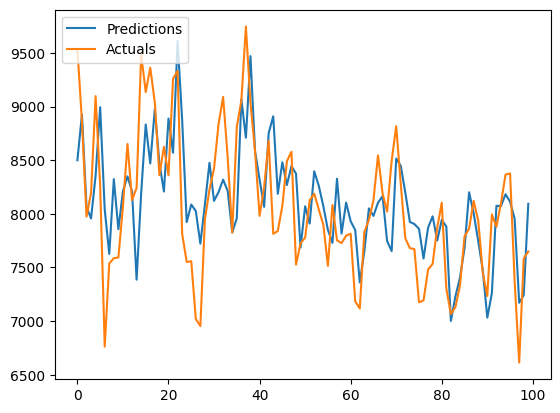

MAPE: 3.74%
RMSE: 385.79
MAE : 296.42


Predictions      Actuals
0    8498.971680  9537.097917
1    8924.721680  8863.333125
2    8064.723633  7973.787500
3    7956.862793  8194.981667
4    8355.868164  9096.434375
..           ...          ...
353  8055.195312  8447.030417
354  8428.572266  8771.408958
355  8347.356445  8487.014792
356  7837.979980  8380.489792
357  7720.913574  8437.980833

[358 rows x 2 columns]

In [76]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


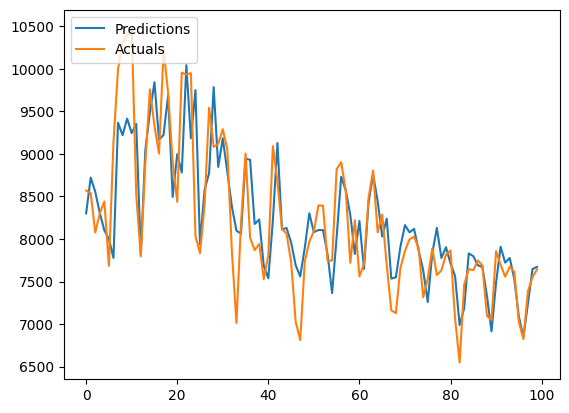

MAPE: 3.83%
RMSE: 406.04
MAE : 303.47


Predictions      Actuals
0    8301.684570  8569.568125
1    8721.568359  8540.904167
2    8555.440430  8076.513125
3    8304.266602  8302.971875
4    8100.771973  8440.820000
..           ...          ...
353  7805.124023  7508.199792
354  7869.553223  7694.271458
355  7870.673340  7746.240833
356  7838.743652  8321.401042
357  8063.980957  8503.726875

[358 rows x 2 columns]

In [77]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

## Model 5 ##

In [79]:
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

tempDemandDF3 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [80]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

i = X_train5.shape[1]
j = X_train5.shape[2]

In [81]:
model5 = Sequential()
model5.add(InputLayer((i, j)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0589 - root_mean_squared_error: 0.2381 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0212 - root_mean_squared_error: 0.1454 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


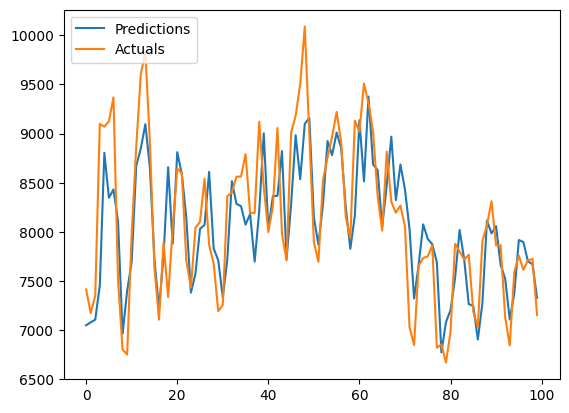

MAPE: 3.74%
RMSE: 412.31
MAE : 302.88


Predictions      Actuals
0    7048.451172  7412.811667
1    7077.948730  7171.183125
2    7105.815430  7350.264167
3    7453.179688  9098.258333
4    8804.242188  9070.002917
..           ...          ...
719  7846.070312  7374.332292
720  7958.191895  8039.583333
721  8287.388672  8575.767292
722  8466.109375  7909.507917
723  7618.154297  7144.386250

[724 rows x 2 columns]

In [83]:
model5 = load_model('model5.keras')

predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


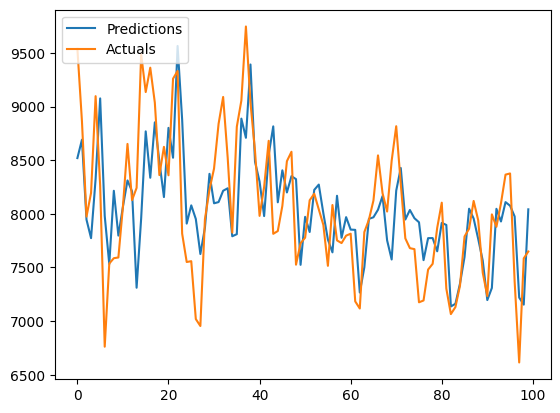

MAPE: 3.73%
RMSE: 390.47
MAE : 297.20


Predictions      Actuals
0    8519.414062  9537.097917
1    8690.349609  8863.333125
2    7945.269043  7973.787500
3    7773.332031  8194.981667
4    8325.928711  9096.434375
..           ...          ...
353  7959.290527  8447.030417
354  8260.856445  8771.408958
355  8077.074707  8487.014792
356  7608.265137  8380.489792
357  7564.436523  8437.980833

[358 rows x 2 columns]

In [84]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


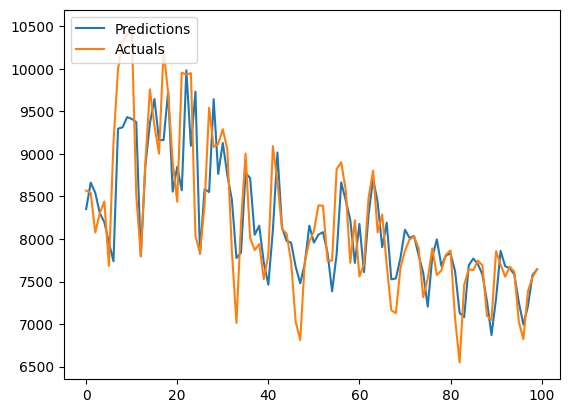

MAPE: 3.78%
RMSE: 408.44
MAE : 301.79


Predictions      Actuals
0    8351.293945  8569.568125
1    8662.354492  8540.904167
2    8543.231445  8076.513125
3    8304.871094  8302.971875
4    8197.651367  8440.820000
..           ...          ...
353  7645.669434  7508.199792
354  7842.412598  7694.271458
355  7695.362305  7746.240833
356  7764.893555  8321.401042
357  8033.021484  8503.726875

[358 rows x 2 columns]

In [85]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

## Model 6 ##

In [86]:
tempDemandDF4 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [87]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

i = X_train6.shape[1]
j = X_train6.shape[2]

In [88]:
model6 = Sequential()
model6.add(InputLayer((i, j)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0824 - root_mean_squared_error: 0.2804 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0229 - root_mean_squared_error: 0.1510 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1313 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


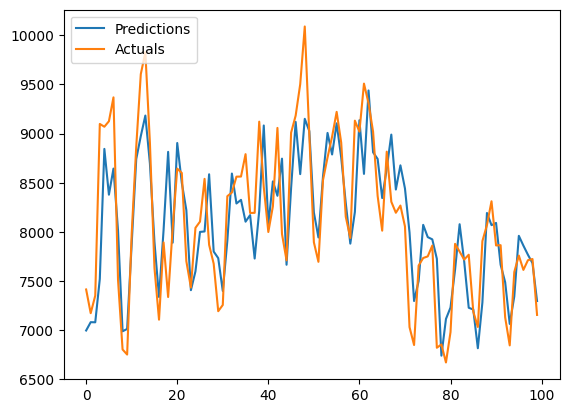

MAPE: 3.65%
RMSE: 397.10
MAE : 294.51


Predictions      Actuals
0    6995.081055  7412.811667
1    7079.795410  7171.183125
2    7078.630859  7350.264167
3    7520.281738  9098.258333
4    8844.222656  9070.002917
..           ...          ...
719  7658.822754  7374.332292
720  8081.521973  8039.583333
721  8299.842773  8575.767292
722  8373.059570  7909.507917
723  7517.302734  7144.386250

[724 rows x 2 columns]

In [90]:
model6 = load_model('model6.keras')
predictions_plot(model6, X_train6, y_train6, 0, 100)

In [91]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


MAPE: 3.68%
RMSE: 385.22
MAE : 292.12


Predictions      Actuals
0    8379.772461  9537.097917
1    8850.570312  8863.333125
2    7938.080566  7973.787500
3    7970.991699  8194.981667
4    8324.209961  9096.434375
..           ...          ...
353  8044.575195  8447.030417
354  8269.193359  8771.408958
355  8091.958008  8487.014792
356  7698.030762  8380.489792
357  7649.480469  8437.980833

[358 rows x 2 columns]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


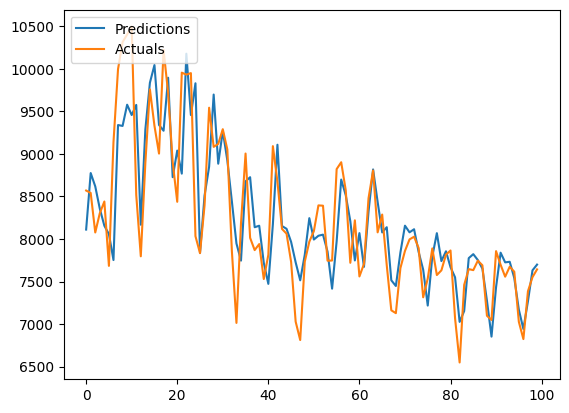

MAPE: 3.82%
RMSE: 404.77
MAE : 303.57


Predictions      Actuals
0    8110.764648  8569.568125
1    8775.143555  8540.904167
2    8618.389648  8076.513125
3    8355.891602  8302.971875
4    8155.779297  8440.820000
..           ...          ...
353  7776.181641  7508.199792
354  7823.607910  7694.271458
355  7720.226562  7746.240833
356  7714.042969  8321.401042
357  7958.639160  8503.726875

[358 rows x 2 columns]

In [92]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

## Increase Window Size to 10 ##

## Model 7 ##

In [93]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

i = X_train7.shape[1]
j = X_train7.shape[2]

In [94]:
model7 = Sequential()
model7.add(InputLayer((i, j)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0273 - root_mean_squared_error: 0.1650 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1115
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1274 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0161 - root_mean_squared_error: 0.1266 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1098
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


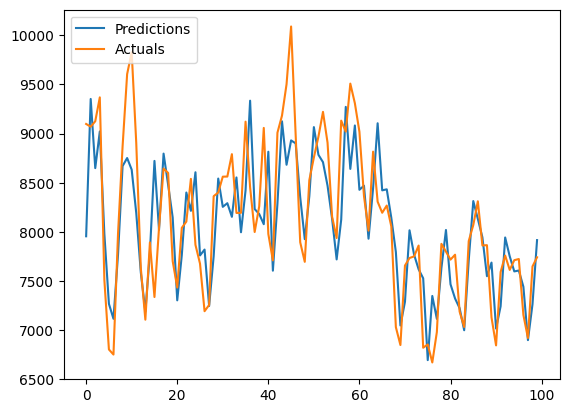

MAPE: 3.82%
RMSE: 407.93
MAE : 310.13


Predictions      Actuals
0    7954.423340  9098.258333
1    9352.699219  9070.002917
2    8648.480469  9125.678750
3    9021.949219  9368.951875
4    7978.632812  7510.325833
..           ...          ...
716  7493.717773  7374.332292
717  7776.369629  8039.583333
718  8013.119141  8575.767292
719  8096.268555  7909.507917
720  7239.150879  7144.386250

[721 rows x 2 columns]

In [96]:
model7 = load_model('model7.keras')

predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


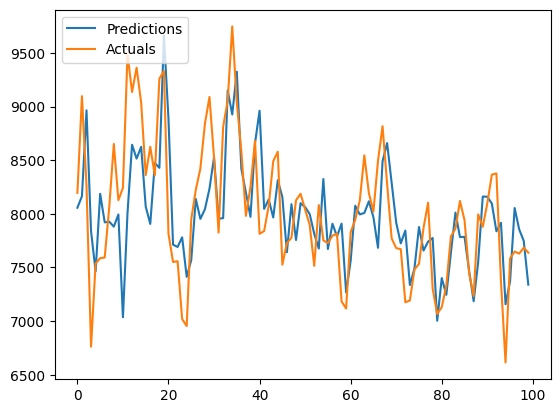

MAPE: 3.79%
RMSE: 392.26
MAE : 303.20


Predictions      Actuals
0    8056.800781  8194.981667
1    8163.611816  9096.434375
2    8964.177734  8261.405417
3    7836.470215  6761.608125
4    7463.677734  7536.762292
..           ...          ...
350  7875.688965  8447.030417
351  8263.361328  8771.408958
352  8286.548828  8487.014792
353  7755.744141  8380.489792
354  7788.973633  8437.980833

[355 rows x 2 columns]

In [97]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


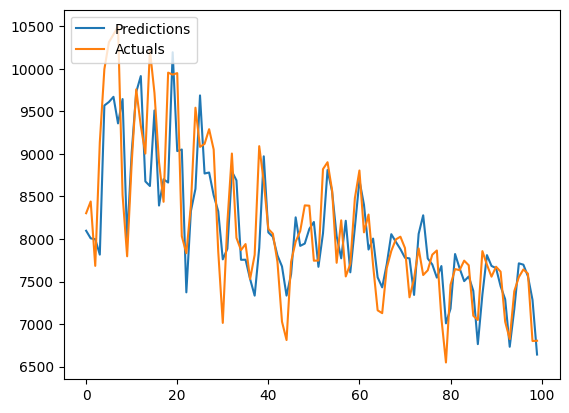

MAPE: 3.97%
RMSE: 413.47
MAE : 317.30


Predictions      Actuals
0    8097.061035  8302.971875
1    8007.441406  8440.820000
2    7997.979980  7684.176042
3    7816.736328  9135.772083
4    9568.777344  9995.508542
..           ...          ...
350  7609.753906  7508.199792
351  7703.743652  7694.271458
352  7781.820312  7746.240833
353  7717.363770  8321.401042
354  8238.883789  8503.726875

[355 rows x 2 columns]

In [98]:
predictions_plot(model7, X_test7, y_test7, 0, 100)

## Model 8 - Decrease Window Size to 5 ##

In [99]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

i = X_train8.shape[1]
j = X_train8.shape[2]

In [100]:
model8 = Sequential()
model8.add(InputLayer((i, j)))
model8.add(LSTM(64))
model8.add(Dense(8, 'tanh'))
model8.add(Dense(1, 'linear'))

model8.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1163 - root_mean_squared_error: 0.3323 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1362
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0242 - root_mean_squared_error: 0.1556 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0192 - root_mean_squared_error: 0.1383 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0181 - root_mean_squared_error: 0.1343 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0176 - root_mean_squared_error: 0.1324 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


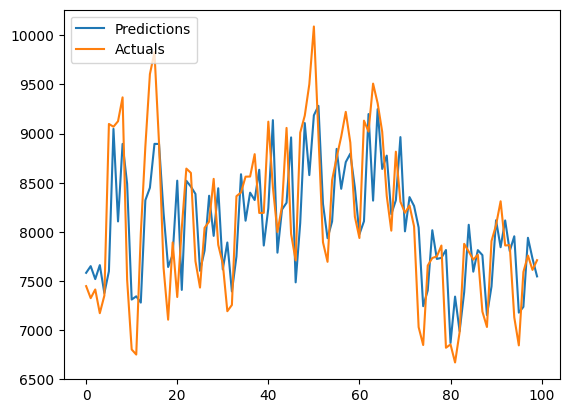

MAPE: 4.34%
RMSE: 461.69
MAE : 348.77


Predictions      Actuals
0    7582.299316  7446.897083
1    7650.382812  7324.388958
2    7518.493652  7412.811667
3    7660.814941  7171.183125
4    7375.378418  7350.264167
..           ...          ...
721  7354.436523  7374.332292
722  7779.382812  8039.583333
723  8068.251465  8575.767292
724  8322.429688  7909.507917
725  7430.934082  7144.386250

[726 rows x 2 columns]

In [102]:
model8 = load_model('model8.keras')

predictions_plot(model8, X_train8, y_train8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


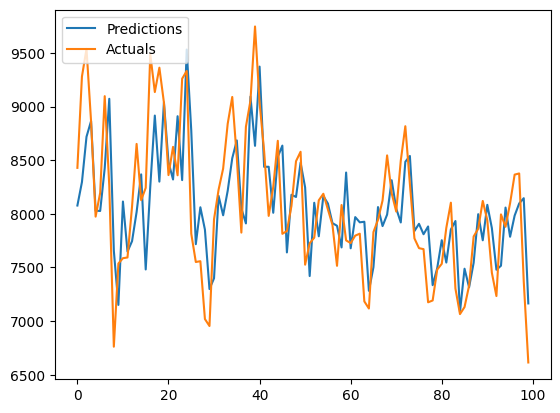

MAPE: 4.03%
RMSE: 405.55
MAE : 319.88


Predictions      Actuals
0    8077.234375  8428.290208
1    8295.828125  9279.195417
2    8718.081055  9537.097917
3    8863.967773  8863.333125
4    8029.487305  7973.787500
..           ...          ...
355  7679.972656  8447.030417
356  8241.846680  8771.408958
357  8195.311523  8487.014792
358  7995.356445  8380.489792
359  8118.466309  8437.980833

[360 rows x 2 columns]

In [103]:
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


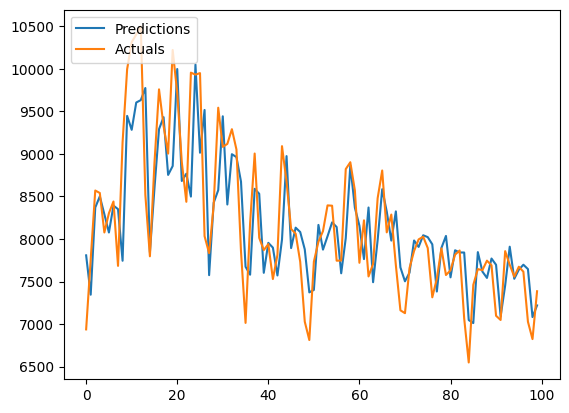

MAPE: 4.22%
RMSE: 435.89
MAE : 332.90


Predictions      Actuals
0    7807.891113  6937.700208
1    7345.481445  7759.521667
2    8369.855469  8569.568125
3    8500.457031  8540.904167
4    8290.805664  8076.513125
..           ...          ...
355  7577.749023  7508.199792
356  7743.022461  7694.271458
357  7725.649414  7746.240833
358  7754.697754  8321.401042
359  8259.972656  8503.726875

[360 rows x 2 columns]

In [104]:
predictions_plot(model8, X_test8, y_test8, 0, 100)

## Model 9 - Increase Window Size to 14 ##

In [105]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

i = X_train9.shape[1]
j = X_train9.shape[2]

In [106]:
model9 = Sequential()
model9.add(InputLayer((i, j)))
model9.add(LSTM(64))
model9.add(Dense(8, 'tanh'))
model9.add(Dense(1, 'linear'))

model9.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0598 - root_mean_squared_error: 0.2411 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0197 - root_mean_squared_error: 0.1403 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1107
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


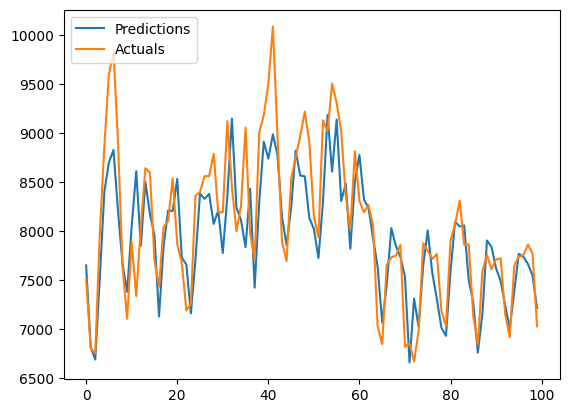

MAPE: 3.60%
RMSE: 399.35
MAE : 294.68


Predictions      Actuals
0    7649.664062  7510.325833
1    6815.555664  6801.918750
2    6688.603516  6750.140625
3    7524.225586  7981.096667
4    8403.256836  8868.038333
..           ...          ...
712  7364.482422  7374.332292
713  7434.403320  8039.583333
714  7793.566406  8575.767292
715  7870.867676  7909.507917
716  7286.272949  7144.386250

[717 rows x 2 columns]

In [108]:
model9 = load_model('model9.keras')

predictions_plot(model9, X_train9, y_train9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


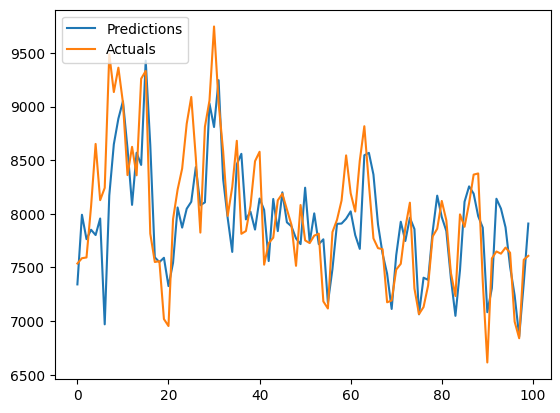

MAPE: 3.62%
RMSE: 372.42
MAE : 291.61


Predictions      Actuals
0    7342.276367  7536.762292
1    7991.167480  7586.311250
2    7763.578613  7593.115208
3    7851.461426  8067.645208
4    7802.177246  8651.321042
..           ...          ...
346  7827.219238  8447.030417
347  8078.257324  8771.408958
348  8080.631836  8487.014792
349  7586.284668  8380.489792
350  7873.225586  8437.980833

[351 rows x 2 columns]

In [109]:
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


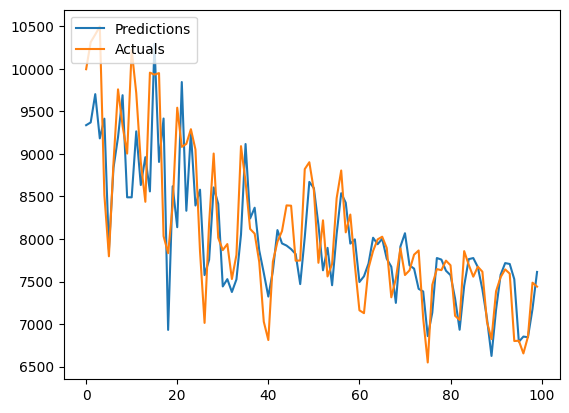

MAPE: 3.92%
RMSE: 418.27
MAE : 314.83


Predictions       Actuals
0    9337.576172   9995.508542
1    9370.036133  10313.686458
2    9702.319336  10402.964375
3    9182.635742  10497.618958
4    9414.004883   8517.349375
..           ...           ...
346  7562.903320   7508.199792
347  7621.134277   7694.271458
348  7823.521484   7746.240833
349  7803.663574   8321.401042
350  8213.392578   8503.726875

[351 rows x 2 columns]

In [110]:
predictions_plot(model9, X_test9, y_test9, 0, 100)

## Model 10 - Add CDD/HDD ##

In [111]:
tempDemandDF5 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [113]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

i = X_train10.shape[1]
j = X_train10.shape[2]

In [114]:
model10 = Sequential()
model10.add(InputLayer((i, j)))
model10.add(LSTM(64))
model10.add(Dense(8, 'tanh'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0956 - root_mean_squared_error: 0.2995 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1288
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0195 - root_mean_squared_error: 0.1396 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1215
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1177
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


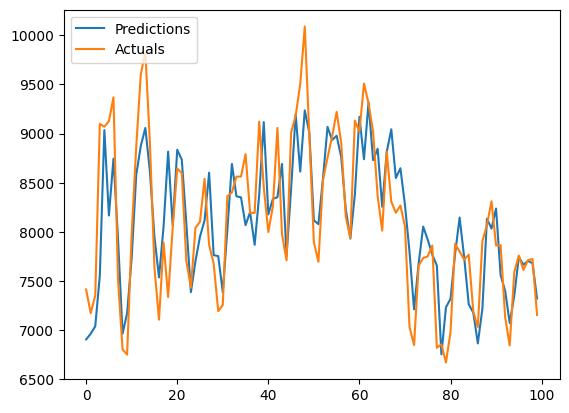

MAPE: 3.57%
RMSE: 392.61
MAE : 286.34


Predictions      Actuals
0    6903.923340  7412.811667
1    6961.973633  7171.183125
2    7037.912598  7350.264167
3    7553.202637  9098.258333
4    9035.974609  9070.002917
..           ...          ...
719  7930.540527  7374.332292
720  8111.315430  8039.583333
721  8237.678711  8575.767292
722  8255.588867  7909.507917
723  7277.390625  7144.386250

[724 rows x 2 columns]

In [116]:
model10 = load_model('model10.keras')
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


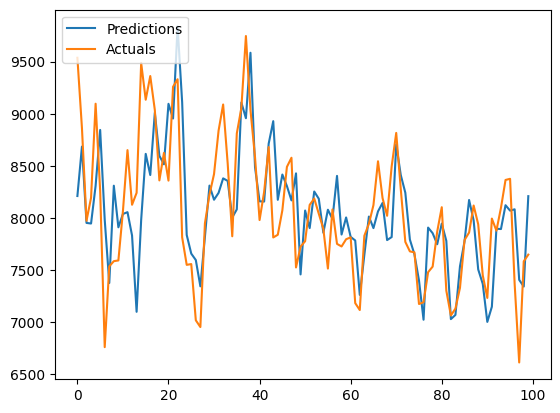

MAPE: 3.67%
RMSE: 385.84
MAE : 291.78


Predictions      Actuals
0    8211.125000  9537.097917
1    8685.014648  8863.333125
2    7953.099609  7973.787500
3    7947.413574  8194.981667
4    8309.336914  9096.434375
..           ...          ...
353  7971.233398  8447.030417
354  8257.676758  8771.408958
355  8259.267578  8487.014792
356  7721.323242  8380.489792
357  7657.840820  8437.980833

[358 rows x 2 columns]

In [117]:
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


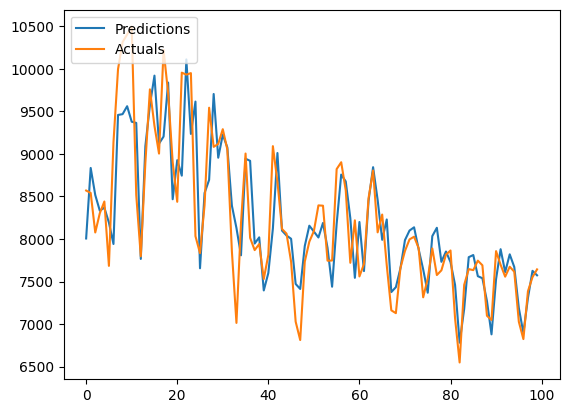

MAPE: 3.87%
RMSE: 407.94
MAE : 306.84


Predictions      Actuals
0    8006.119629  8569.568125
1    8834.996094  8540.904167
2    8517.180664  8076.513125
3    8332.791992  8302.971875
4    8368.265625  8440.820000
..           ...          ...
353  7898.131836  7508.199792
354  7925.691406  7694.271458
355  7947.404785  7746.240833
356  7850.118652  8321.401042
357  7749.779297  8503.726875

[358 rows x 2 columns]

In [118]:
predictions_plot(model10, X_test10, y_test10, 0, 100)

## Model 11 - Remove Avg Temp from Model 10 ##

In [119]:
tempDemandDF6 = test_df[['avg_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [120]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

i = X_train11.shape[1]
j = X_train11.shape[2]

In [121]:
model11 = Sequential()
model11.add(InputLayer((i, j)))
model11.add(LSTM(64))
model11.add(Dense(8, 'tanh'))
model11.add(Dense(1, 'linear'))

model11.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0841 - root_mean_squared_error: 0.2819 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1177
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1290 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


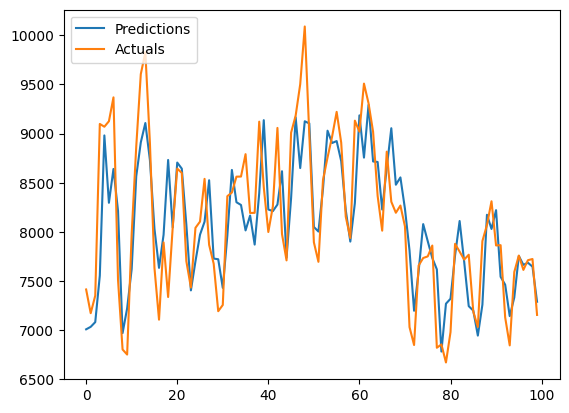

MAPE: 3.62%
RMSE: 401.03
MAE : 291.72


Predictions      Actuals
0    7007.131348  7412.811667
1    7032.325195  7171.183125
2    7080.484863  7350.264167
3    7553.844727  9098.258333
4    8981.389648  9070.002917
..           ...          ...
719  7932.715332  7374.332292
720  8148.373535  8039.583333
721  8187.336426  8575.767292
722  8193.371094  7909.507917
723  7425.623047  7144.386250

[724 rows x 2 columns]

In [123]:
model11 = load_model('model11.keras')

predictions_plot(model11, X_train11, y_train11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


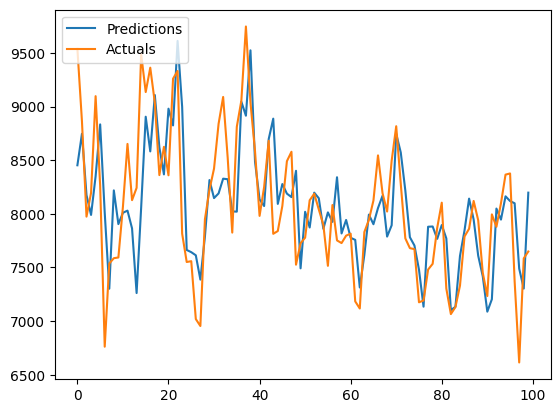

MAPE: 3.58%
RMSE: 371.97
MAE : 284.31


Predictions      Actuals
0    8452.320312  9537.097917
1    8745.897461  8863.333125
2    8174.339844  7973.787500
3    7989.385742  8194.981667
4    8349.890625  9096.434375
..           ...          ...
353  7950.935059  8447.030417
354  8228.381836  8771.408958
355  8269.749023  8487.014792
356  7862.785645  8380.489792
357  7858.810059  8437.980833

[358 rows x 2 columns]

In [124]:
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


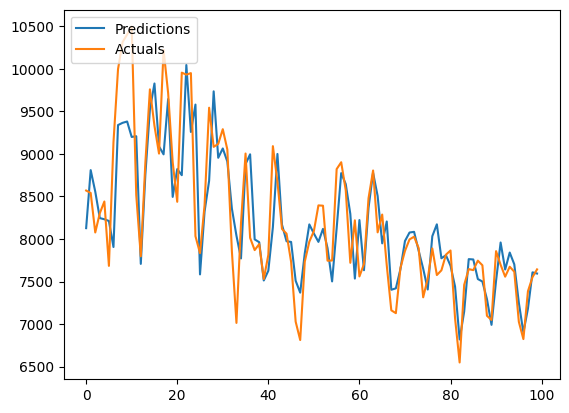

MAPE: 3.95%
RMSE: 413.80
MAE : 313.65


Predictions      Actuals
0    8127.525879  8569.568125
1    8809.520508  8540.904167
2    8556.995117  8076.513125
3    8245.652344  8302.971875
4    8232.119141  8440.820000
..           ...          ...
353  7845.984863  7508.199792
354  7873.165039  7694.271458
355  7880.047363  7746.240833
356  7789.665527  8321.401042
357  7889.481934  8503.726875

[358 rows x 2 columns]

In [125]:
predictions_plot(model11, X_test11, y_test11, 0, 100)

## Introduce Other Weather Features ##

## Model 12 - Precipitation ##

In [126]:
tempPrecipDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'temp_range']].copy()

In [127]:
preprocessor = TimeSeriesPreprocessorTVT(tempPrecipDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

i = X_train12.shape[1]
j = X_train12.shape[2]

In [129]:
model12 = Sequential()
model12.add(InputLayer((i, j)))
model12.add(LSTM(64))
model12.add(Dense(8, 'tanh'))
model12.add(Dense(1, 'linear'))

model12.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp14, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1785 - root_mean_squared_error: 0.4074 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1447
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0233 - root_mean_squared_error: 0.1526 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - root_mean_squared_error: 0.1282 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - root_mean_squared_error: 0.1260 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


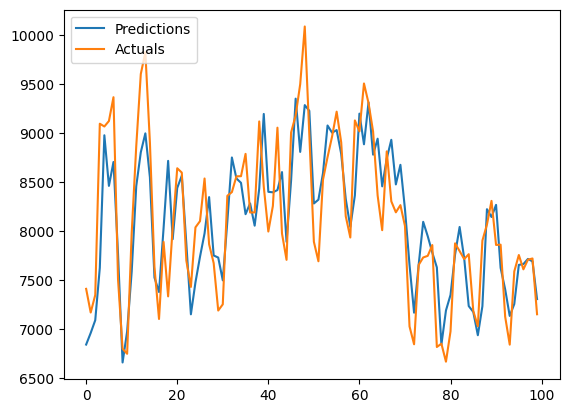

MAPE: 3.46%
RMSE: 376.19
MAE : 278.18


Predictions      Actuals
0    6844.279785  7412.811667
1    6962.450195  7171.183125
2    7092.946289  7350.264167
3    7627.626953  9098.258333
4    8980.385742  9070.002917
..           ...          ...
719  7891.740234  7374.332292
720  8145.828125  8039.583333
721  8199.235352  8575.767292
722  7971.990234  7909.507917
723  7346.895996  7144.386250

[724 rows x 2 columns]

In [131]:
model12 = load_model('model12.keras')

predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


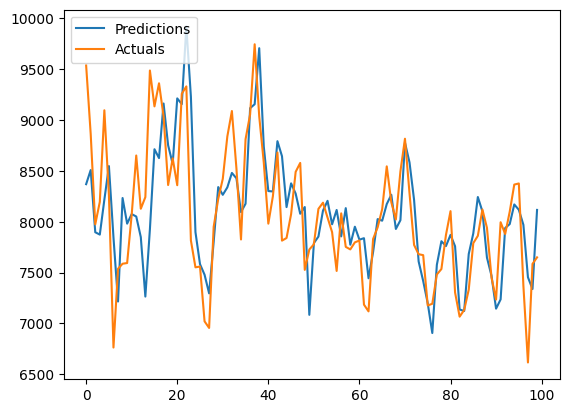

MAPE: 3.56%
RMSE: 370.51
MAE : 282.85


Predictions      Actuals
0    8369.203125  9537.097917
1    8508.169922  8863.333125
2    7896.140625  7973.787500
3    7872.920898  8194.981667
4    8216.728516  9096.434375
..           ...          ...
353  8020.532227  8447.030417
354  8348.751953  8771.408958
355  8381.856445  8487.014792
356  7949.099121  8380.489792
357  7842.270996  8437.980833

[358 rows x 2 columns]

In [132]:
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


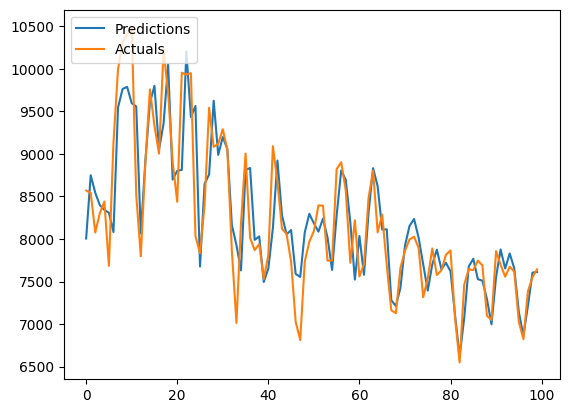

MAPE: 3.86%
RMSE: 398.35
MAE : 305.43


Predictions      Actuals
0    8005.551758  8569.568125
1    8749.173828  8540.904167
2    8543.815430  8076.513125
3    8398.664062  8302.971875
4    8343.167969  8440.820000
..           ...          ...
353  7987.836426  7508.199792
354  8094.389160  7694.271458
355  8048.831055  7746.240833
356  7953.152832  8321.401042
357  7918.057617  8503.726875

[358 rows x 2 columns]

In [133]:
predictions_plot(model12, X_test12, y_test12, 0, 100)

## Model 13 - Sunlight ##

In [134]:
tempSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight', 'temp_range']].copy()

In [135]:
preprocessor = TimeSeriesPreprocessorTVT(tempSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

i = X_train13.shape[1]
j = X_train13.shape[2]

In [136]:
model13 = Sequential()
model13.add(InputLayer((i, j)))
model13.add(LSTM(64))
model13.add(Dense(8, 'tanh'))
model13.add(Dense(1, 'linear'))

model13.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1253 - root_mean_squared_error: 0.3419 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1324
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202 - root_mean_squared_error: 0.1419 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1181
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


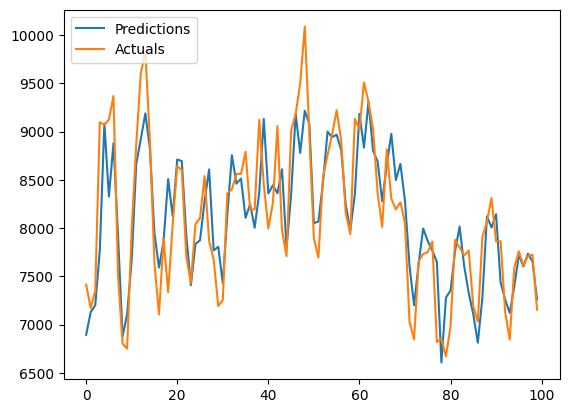

MAPE: 3.53%
RMSE: 384.70
MAE : 282.98


Predictions      Actuals
0    6893.117188  7412.811667
1    7128.439453  7171.183125
2    7200.928711  7350.264167
3    7766.702148  9098.258333
4    9082.718750  9070.002917
..           ...          ...
719  7797.964355  7374.332292
720  8257.934570  8039.583333
721  8220.798828  8575.767292
722  8056.277344  7909.507917
723  7219.826660  7144.386250

[724 rows x 2 columns]

In [138]:
model13 = load_model('model13.keras')
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


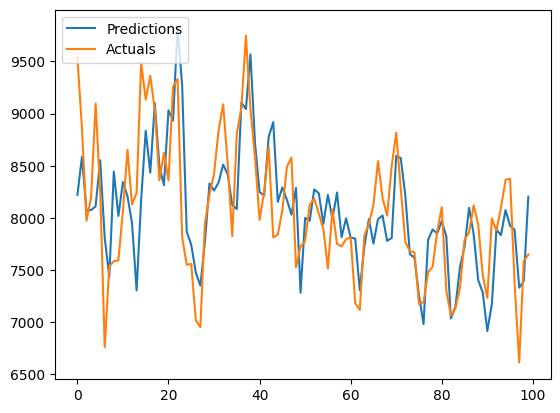

MAPE: 3.72%
RMSE: 387.18
MAE : 295.23


Predictions      Actuals
0    8221.081055  9537.097917
1    8584.663086  8863.333125
2    8071.479980  7973.787500
3    8075.270996  8194.981667
4    8111.407227  9096.434375
..           ...          ...
353  8165.043945  8447.030417
354  8458.116211  8771.408958
355  8449.470703  8487.014792
356  8062.518555  8380.489792
357  7966.422363  8437.980833

[358 rows x 2 columns]

In [139]:
predictions_plot(model13, X_val13, y_val13, 0, 100)

In [140]:
predictions_plot(model13, X_test13, y_test13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


MAPE: 3.88%
RMSE: 404.79
MAE : 306.61


Predictions      Actuals
0    7702.655762  8569.568125
1    8825.203125  8540.904167
2    8651.778320  8076.513125
3    8207.728516  8302.971875
4    8237.991211  8440.820000
..           ...          ...
353  7966.396973  7508.199792
354  8011.283203  7694.271458
355  8092.945312  7746.240833
356  7945.764648  8321.401042
357  7935.843750  8503.726875

[358 rows x 2 columns]

## Model 14 - Precipitation and Sunlight ##

In [160]:
tempPreSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight', 'temp_range']].copy()


In [161]:
preprocessor = TimeSeriesPreprocessorTVT(tempPreSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

i = X_train14.shape[1]
j = X_train14.shape[2]

In [162]:
model14 = Sequential()
model14.add(InputLayer((i, j)))
model14.add(LSTM(64))
model14.add(Dense(8, 'tanh'))
model14.add(Dense(1, 'linear'))

model14.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [163]:
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0418 - root_mean_squared_error: 0.2028 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - root_mean_squared_error: 0.1257 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


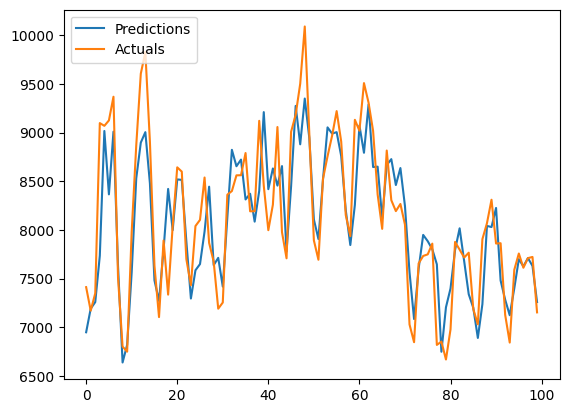

MAPE: 3.31%
RMSE: 362.70
MAE : 266.23


Predictions      Actuals
0    6949.327637  7412.811667
1    7191.468750  7171.183125
2    7259.380859  7350.264167
3    7735.554199  9098.258333
4    9017.108398  9070.002917
..           ...          ...
719  7669.877441  7374.332292
720  8184.467773  8039.583333
721  8263.702148  8575.767292
722  8029.078613  7909.507917
723  7298.580078  7144.386250

[724 rows x 2 columns]

In [164]:
model14 = load_model('model14.keras')

predictions_plot(model14, X_train14, y_train14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


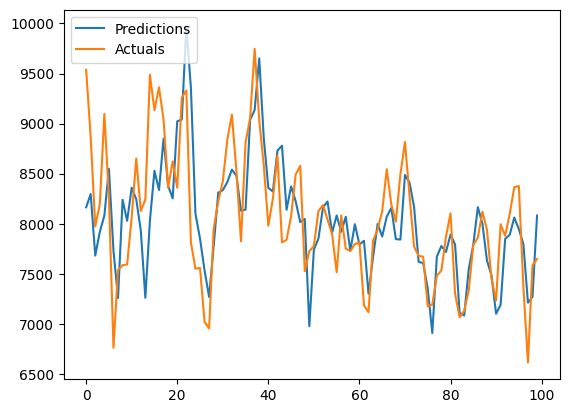

MAPE: 3.53%
RMSE: 373.67
MAE : 280.49


Predictions      Actuals
0    8164.162598  9537.097917
1    8296.564453  8863.333125
2    7682.118652  7973.787500
3    7917.838379  8194.981667
4    8081.252930  9096.434375
..           ...          ...
353  8288.226562  8447.030417
354  8629.081055  8771.408958
355  8682.207031  8487.014792
356  8194.872070  8380.489792
357  8050.995605  8437.980833

[358 rows x 2 columns]

In [165]:
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


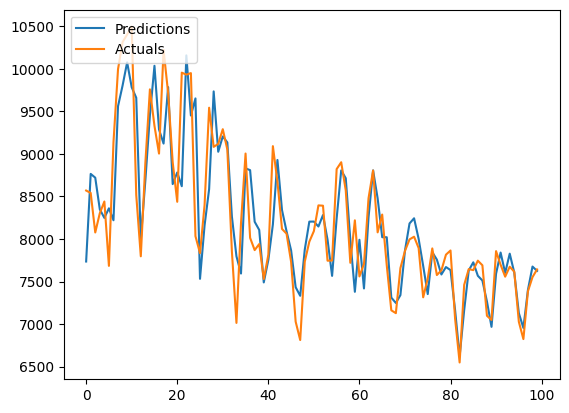

MAPE: 3.84%
RMSE: 397.24
MAE : 302.47


Predictions      Actuals
0    7735.439453  8569.568125
1    8765.195312  8540.904167
2    8720.621094  8076.513125
3    8348.392578  8302.971875
4    8248.351562  8440.820000
..           ...          ...
353  8093.915527  7508.199792
354  8111.193848  7694.271458
355  8233.680664  7746.240833
356  8061.983887  8321.401042
357  8065.024414  8503.726875

[358 rows x 2 columns]

In [166]:
predictions_plot(model14, X_test14, y_test14, 0, 100)

In [167]:
plt.plot(history14.history['loss'], label='Train Loss')
plt.plot(history14.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasonality ##

## Seasons ##

In [ ]:
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

i = X_train15.shape[1]
j = X_train15.shape[2]

In [ ]:
model15 = Sequential()
model15.add(InputLayer((i, j)))
model15.add(LSTM(64))
model15.add(Dense(8, 'tanh'))
model15.add(Dense(1, 'linear'))

model15.summary()

In [ ]:
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es])

In [ ]:
model15 = load_model('model15.keras')

predictions_plot(model15, X_train15, y_train15, 0, 100)

In [ ]:
predictions_plot(model15, X_val15, y_val15, 0, 100)

In [ ]:
predictions_plot(model15, X_test15, y_test15, 0, 100)

## Weekday/Weekend ##

In [ ]:
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

i = X_train16.shape[1]
j = X_train16.shape[2]

In [ ]:
model16 = Sequential()
model16.add(InputLayer((7, 9)))
model16.add(LSTM(64))
model16.add(Dense(8, 'tanh'))
model16.add(Dense(1, 'linear'))

model16.summary()

In [ ]:
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es])

In [ ]:
model16 = load_model('model16.keras')

predictions_plot(model16, X_train16, y_train16, 0, 100)

In [ ]:
predictions_plot(model16, X_val16, y_val16, 0, 100)

In [ ]:
predictions_plot(model16, X_test16, y_test16, 0, 100)

## Day Of Week ##

In [ ]:
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

i = X_train17.shape[1]
j = X_train17.shape[2]

In [ ]:
model17 = Sequential()
model17.add(InputLayer((i, j)))
model17.add(LSTM(64))
model17.add(Dense(8, 'tanh'))
model17.add(Dense(1, 'linear'))

model17.summary()

In [ ]:
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history17 = model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17, es])

In [ ]:
model17 = load_model('model17.keras')

predictions_plot(model17, X_train17, y_train17, 0, 100)

In [ ]:
predictions_plot(model17, X_val17, y_val17, 0, 100)

In [ ]:
predictions_plot(model17, X_test17, y_test17, 0, 100)

## Month ##

In [ ]:
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

i = X_train18.shape[1]
j = X_train18.shape[2]

In [ ]:
model18 = Sequential()
model18.add(InputLayer((i, j)))
model18.add(LSTM(64))
model18.add(Dense(8, 'tanh'))
model18.add(Dense(1, 'linear'))

model18.summary()

In [ ]:
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history18 = model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18, es])

In [ ]:
model18 = load_model('model18.keras')

predictions_plot(model18, X_train18, y_train18, 0, 100)

In [ ]:
predictions_plot(model18, X_val18, y_val18, 0, 100)

In [ ]:
predictions_plot(model18, X_test18, y_test18, 0, 100)

## Seasons & Weekday/Weekend ##

In [ ]:
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

i = X_train19.shape[1]
j = X_train19.shape[2]

In [ ]:
model19 = Sequential()
model19.add(InputLayer((i, j)))
model19.add(LSTM(64))
model19.add(Dense(8, 'tanh'))
model19.add(Dense(1, 'linear'))

model19.summary()

In [ ]:
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history19 = model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19, es])

In [ ]:
model19 = load_model('model19.keras')

predictions_plot(model19, X_train19, y_train19, 0, 100)

In [ ]:
predictions_plot(model19, X_val19, y_val19, 0, 100)

In [ ]:
predictions_plot(model19, X_test19, y_test19, 0, 100)

## Switch to train/test only - compare Seasons & Seasons/Weekend ##

## Seasons & Weekday/Weekend - Train/Test ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

i = X_train20.shape[1]
j = X_train20.shape[2]

In [ ]:
model20 = Sequential()
model20.add(InputLayer((7, 13)))
model20.add(LSTM(64))
model20.add(Dense(8, 'tanh'))
model20.add(Dense(1, 'linear'))

model20.summary()

In [ ]:
cp20 = ModelCheckpoint('model20.keras', save_best_only=True)
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history20 = model20.fit(X_train20, y_train20, validation_split=0.05, epochs=100, callbacks=[cp20, es])

In [ ]:
model20 = load_model('model20.keras')

predictions_plot(model20, X_train20, y_train20, 0, 1000)

In [ ]:
predictions_plot(model20, X_test20, y_test20, 0, 100)

## Seasons Only - Train/Test ##

In [ ]:
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

i = X_train21.shape[1]
j = X_train21.shape[2]

In [ ]:
model21 = Sequential()
model21.add(InputLayer((i, j)))
model21.add(LSTM(64))
model21.add(Dense(8, 'tanh'))
model21.add(Dense(1, 'linear'))

model21.summary()

In [ ]:
cp21 = ModelCheckpoint('model21.keras', save_best_only=True)
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history21 = model21.fit(X_train21, y_train21, validation_split=0.05, epochs=100, callbacks=[cp21, es])

In [ ]:
model21 = load_model('model21.keras')
predictions_plot(model21, X_train21, y_train21, 0, 100)

In [ ]:
predictions_plot(model21, X_test21, y_test21, 0, 100)

## Weekend/Weekday Only - Train/Test ##

In [ ]:
preprocessor22 = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor22.split()
preprocessor22.scale()
data22 = preprocessor22.get_model_inputs(target_col='avg_30_min_demand')

X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

i = X_train22.shape[1]
j = X_train22.shape[2]

In [ ]:
model22 = Sequential()
model22.add(InputLayer((i, j)))
model22.add(LSTM(64))
model22.add(Dense(8, 'tanh'))
model22.add(Dense(1, 'linear'))

model22.summary()

In [ ]:
cp22 = ModelCheckpoint('model22.keras', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history22 = model22.fit(X_train22, y_train22, validation_split=0.05, epochs=100, callbacks=[cp22, es])

In [ ]:
model22 = load_model('model22.keras')

predictions_plot(model22, X_train22, y_train22, 0, 100)

In [ ]:
predictions_plot(model22, X_test22, y_test22, 0, 100)